### Decision Tree, Random Forests and Other related Techniques

### CART training algorithm 
In order to train a decision tree, various algorithms can be used. In this notebook we will focus on the *CART* algorithm (Classification and Regression Trees) for *classification*. The CART algorithm builds a *binary tree* in which every non-leaf node has exactly two children (corresponding to a yes/no answer). 

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the purest subsets, weighted by their size. Purity/impurity is measured using the *Gini impurity*.

So at each step, the algorithm selects the parameters $\theta$ that minimize the following cost function:

\begin{equation}
J(D, \theta) = \frac{n_{left}}{n_{total}} G_{left} + \frac{n_{right}}{n_{total}} G_{right}
\end{equation}

- $D$: remaining training examples   
- $n_{total}$ : number of remaining training examples
- $\theta = (f, t_f)$: feature and feature threshold
- $n_{left}/n_{right}$: number of samples in the left/right subset
- $G_{left}/G_{right}$: Gini impurity of the left/right subset

This step is repeated recursively until the *maximum allowable depth* is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found [here](http://scikit-learn.org/stable/modules/tree.html).

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.


### Gini Impurity

Given $K$ different classification values $k \in \{1, ..., K\}$ the Gini impurity of node $m$ is computed as follows:

\begin{equation}
G_m = 1 - \sum_{k=1}^{K} (p_{m,k})^2
\end{equation}

where $p_{m, k}$ is the fraction of training examples with class $k$ among all training examples in node $m$.

The Gini impurity can be used to evaluate how good a potential split is. A split divides a given set of training examples into two groups. Gini measures how "mixed" the resulting groups are. A perfect separation (i.e. each group contains only samples of the same class) corresponds to a Gini impurity of 0. If the resulting groups contain equally many samples of each class, the Gini impurity will reach its highest value of 0.5

### Caveats

Without regularization, decision trees are likely to overfit the training examples. This can be prevented using techniques like *pruning* or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further.

### Decision Tree -  A Basic Example

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

iris = load_iris()
data = iris.data
target = iris.target

clf = DecisionTreeClassifier()
clf = clf.fit(data, target)

import graphviz

dot_data = export_graphviz(clf, out_file = None)
graph = graphviz.Source(dot_data)
graph.render('Iris') #Iris.pdf is saved in current directory

'Iris.pdf'

In [4]:
clf.feature_importances_

array([0.01333333, 0.01333333, 0.55072262, 0.42261071])

In [5]:
clf.classes_

array([0, 1, 2])

In [6]:
clf.predict_proba(data)[50:55]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [7]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

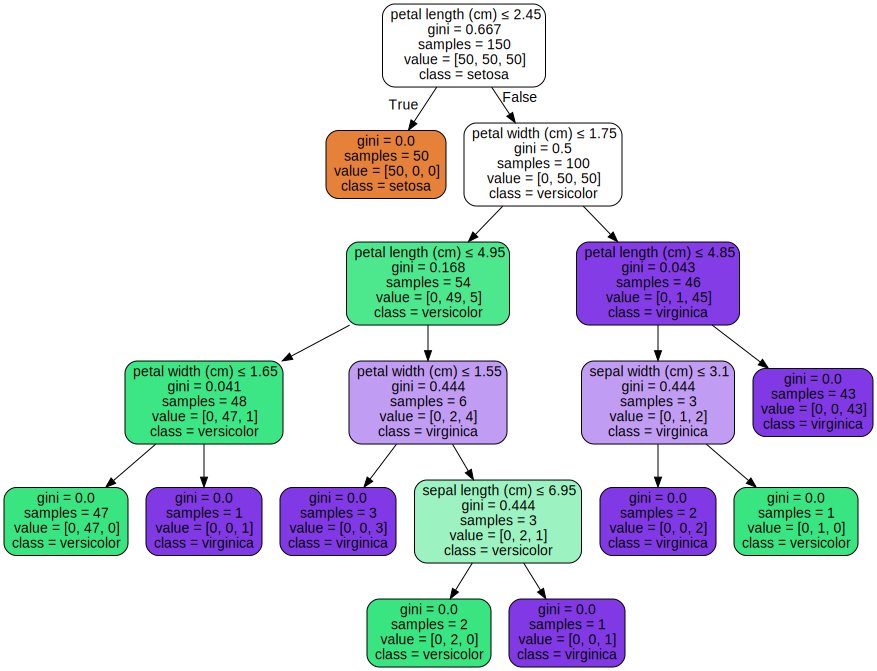

In [8]:
>>> dot_data = export_graphviz(clf, out_file=None,
feature_names=iris.feature_names,
class_names=iris.target_names,
filled=True, rounded=True,
special_characters=True)
>>> graph = graphviz.Source(dot_data)
>>> graph

Below is the basic Python implementation of Decision Tree

In [9]:
class DecisionTree:
    """
    Decision tree for classification
    """

    def __init__(self):
        self.root_dict = None
        self.tree_dict = None

    def split_dataset(self, X, y, feature_idx, threshold):
        """
        Splits dataset X into two subsets, according to a given feature
        and feature threshold.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            feature_idx: int, index of feature used for splitting the data
            threshold: float, threshold used for splitting the data

        Returns:
            splits: dict containing the left and right subsets
            and their labels
        """

        left_idx = np.where(X[:, feature_idx] < threshold)     #array of indices
        right_idx = np.where(X[:, feature_idx] >= threshold)   #array of indices

        left_subset = X[left_idx]               #slice of data
        y_left = y[left_idx]                    #slice of target  

        right_subset = X[right_idx]
        y_right = y[right_idx]

        splits = {
        'left': left_subset,
        'y_left': y_left,
        'right': right_subset,
        'y_right': y_right,
        }

        return splits

    def gini_impurity(self, y_left, y_right, n_left, n_right):
        """
        Computes Gini impurity of a split.

        Args:
            y_left, y_right: target values of samples in left/right subset
            n_left, n_right: number of samples in left/right subset


Returns:
            gini_left: float, Gini impurity of left subset
            gini_right: gloat, Gini impurity of right subset
        """

        n_total = n_left + n_right # ?????????? it should be n_left + n_right

        score_left, score_right = 0, 0
        gini_left, gini_right = 0, 0

        if n_left != 0:
            for c in range(self.n_classes):
                # For each class c, compute fraction of samples with class c
                p_left = len(np.where(y_left == c)[0]) / n_left
                score_left += p_left * p_left
            gini_left = 1 - score_left

        if n_right != 0:
            for c in range(self.n_classes):
                p_right = len(np.where(y_right == c)[0]) / n_right
                score_right += p_right * p_right
            gini_right = 1 - score_right

        return gini_left, gini_right

    def get_cost(self, splits):
        """
        Computes cost of a split given the Gini impurity of
        the left and right subset and the sizes of the subsets
        
        Args:
            splits: dict, containing params of current split
        """
        y_left = splits['y_left']
        y_right = splits['y_right']

        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right

        gini_left, gini_right = self.gini_impurity(y_left, y_right, n_left, n_right)
        cost = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right

        return cost

    def find_best_split(self, X, y):
        """
        Finds the best feature and feature index to split dataset X into
        two groups. Checks every value of every attribute as a candidate
        split.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels

        Returns:
            best_split_params: dict, containing parameters of the best split
        """

        n_samples, n_features = X.shape

        best_feature_idx, best_threshold, best_cost, best_splits = np.inf, np.inf, np.inf, None

        for feature_idx in range(n_features):
            for i in range(n_samples):
                current_sample = X[i]
                threshold = current_sample[feature_idx]
                splits = self.split_dataset(X, y, feature_idx, threshold)
                cost = self.get_cost(splits)

                if cost < best_cost:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_cost = cost
                    best_splits = splits

        best_split_params = {
            'feature_idx': best_feature_idx,
            'threshold': best_threshold,
            'cost': best_cost,
            'left': best_splits['left'],
            'y_left': best_splits['y_left'],
            'right': best_splits['right'],
            'y_right': best_splits['y_right'],
        }

        return best_split_params


    def build_tree(self, node_dict, depth, max_depth, min_samples):
        """
        Builds the decision tree in a recursive fashion.

        Args:
            node_dict: dict, representing the current node
            depth: int, depth of current node in the tree
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further

        Returns:
            node_dict: dict, representing the full subtree originating from current node
        """
        left_samples = node_dict['left']
        right_samples = node_dict['right']
        y_left_samples = node_dict['y_left']
        y_right_samples = node_dict['y_right']

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node_dict["left_child"] = node_dict["right_child"] = self.create_terminal_node(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
        else:
            node_dict["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(node_dict["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
        else:
            node_dict["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(node_dict["left_child"], depth+1, max_depth, min_samples)

        return node_dict

    def create_terminal_node(self, y):
        """
        Creates a terminal node.
        Given a set of labels the most common label is computed and
        set as the classification value of the node.

        Args:
            y: 1D numpy array with labels
        Returns:
            classification: int, predicted class
        """
        classification = max(set(y), key=list(y).count)
        return classification

    def train(self, X, y, max_depth, min_samples):
        """
        Fits decision tree on a given dataset.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further
        """
        self.n_classes = len(set(y))
        self.root_dict = self.find_best_split(X, y)
        self.tree_dict = self.build_tree(self.root_dict, 1, max_depth, min_samples)

    def predict(self, X, node):
        """
        Predicts the class for a given input example X.

        Args:
            X: 1D numpy array, input example
            node: dict, representing trained decision tree

        Returns:
            prediction: int, predicted class
        """
        feature_idx = node['feature_idx']
        threshold = node['threshold']

        if X[feature_idx] < threshold:
            if isinstance(node['left_child'], (int, np.integer)):
                return node['left_child']
            else:
                prediction = self.predict(X, node['left_child'])
        elif X[feature_idx] >= threshold:
            if isinstance(node['right_child'], (int, np.integer)):
                return node['right_child']
            else:
                prediction = self.predict(X, node['right_child'])

        return prediction

In [10]:
tree = DecisionTree()
tree.train(data, target, max_depth=2, min_samples=1)

In [11]:
tree.find_best_split(data,target)

{'feature_idx': 2,
 'threshold': 3.0,
 'cost': 0.3333333333333333,
 'left': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0

In [12]:
def print_tree(node, depth=0):
    if isinstance(node, (int, np.integer)):
        print(f"{depth * '  '}predicted class: {iris.target_names[node]}")
    else:
        print(f"{depth * '  '}{iris.feature_names[node['feature_idx']]} < {node['threshold']}, "
             f"cost of split: {round(node['cost'], 3)}")
        print_tree(node["left_child"], depth+1)
        print_tree(node["right_child"], depth+1)

In [13]:
print_tree(tree.tree_dict)

petal length (cm) < 3.0, cost of split: 0.333
  sepal length (cm) < 5.1, cost of split: 0.0
    predicted class: setosa
    predicted class: setosa
  petal width (cm) < 1.8, cost of split: 0.11
    predicted class: versicolor
    predicted class: virginica


In [14]:
a = np.array([4.9,3.1,1.3,.2])
tree.predict(a, tree.tree_dict) #output will be class

0


#### Calculating Gini Impurity and Cost for a Given Split

In [15]:
import pandas as pd
df = pd.DataFrame(data)
df.columns = iris.feature_names
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [16]:
np.unique(data[:,3])

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

In [17]:
left_idx = np.where(data[:,3] <.8)
left_idx

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)

In [18]:
left_idx[0].shape

(50,)

In [19]:
y_left = target[left_idx]
y_left

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [20]:
right_idx = np.where(data[:,3] >= .8)
right_idx[0].shape

(100,)

In [21]:
y_right = target[right_idx]
y_right


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [22]:
n_left = len(y_left)
n_right = len(y_right)
n_left, n_right

(50, 100)

In [23]:
score_left = 0
if n_left != 0:
    for c in range(3):
        p_left = len(np.where(y_left == c)[0]) / n_left
        score_left += (p_left * p_left)
    gini_left = 1 - score_left
gini_left    

0.0

In [24]:
score_right = 0
if n_right != 0:
    for c in range(3):
        p_right = len(np.where(y_right == c)[0]) / n_right
        score_right += (p_right * p_right)
    gini_right = 1 - score_right
gini_right            

0.5

In [25]:
n_total = n_left + n_right

In [32]:
cost = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
cost

0.3333333333333333

In [26]:
y_right = target[right_idx]
y_right



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

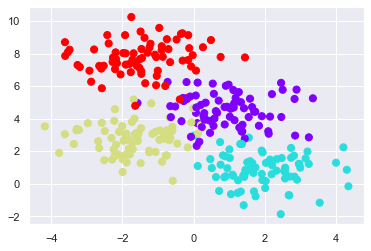

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

from sklearn.tree import DecisionTreeClassifier
mod = DecisionTreeClassifier()
mod.fit(X,y)


Instead of looking at the whole tree, which can be taxing, there are some useful statistics that we can derive properties that we can derive to summarize the workings of the tree. The most commonly used summary is feature importance, which rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target”.

In [28]:
mod.classes_, mod.max_features_, mod.feature_importances_, mod.score(X,y), mod.n_outputs_


(array([0, 1, 2, 3]), 2, array([0.32287029, 0.67712971]), 1.0, 1)

In [29]:

mod.predict_proba(X)


array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [30]:
X[:2]

array([[ 0.02458305,  2.96215652],
       [-1.52392631,  7.12573205]])

In [31]:
y

array([1, 3, 0, 3, 1, 1, 2, 0, 3, 3, 2, 3, 0, 3, 1, 0, 0, 1, 2, 2, 1, 1,
       0, 2, 2, 0, 1, 0, 2, 0, 3, 3, 0, 3, 3, 3, 3, 3, 2, 1, 0, 2, 0, 0,
       2, 2, 3, 2, 3, 1, 2, 1, 3, 1, 1, 2, 3, 2, 3, 1, 3, 0, 3, 2, 2, 2,
       3, 1, 3, 2, 0, 2, 3, 2, 2, 3, 2, 0, 1, 3, 1, 0, 1, 1, 3, 0, 1, 0,
       3, 3, 0, 1, 3, 2, 2, 0, 1, 1, 0, 2, 3, 1, 3, 1, 0, 1, 1, 0, 3, 0,
       2, 2, 1, 3, 1, 0, 3, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 3, 2,
       2, 1, 3, 2, 2, 3, 0, 3, 3, 2, 0, 2, 0, 2, 3, 0, 3, 3, 3, 0, 3, 0,
       1, 2, 3, 2, 1, 0, 3, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 3, 1, 0, 2, 3,
       1, 1, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0, 2, 2, 2, 0,
       2, 3, 0, 2, 1, 2, 0, 3, 2, 3, 0, 3, 0, 2, 0, 0, 3, 2, 2, 1, 1, 0,
       3, 1, 1, 2, 1, 2, 0, 3, 3, 0, 0, 3, 0, 1, 2, 0, 1, 2, 3, 2, 1, 0,
       1, 3, 3, 3, 3, 2, 2, 3, 0, 2, 1, 0, 2, 2, 2, 1, 1, 3, 0, 0, 2, 1,
       3, 2, 0, 3, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 3, 3, 1, 1, 0, 1, 1, 1,
       3, 2, 3, 0, 1, 1, 3, 3, 3, 1, 1, 0, 3, 2])

##### Above Example with Visualization

/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'clim'


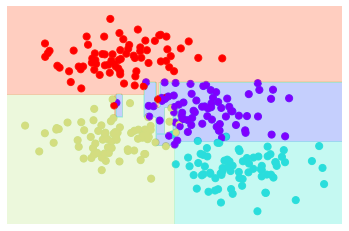

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

from sklearn.tree import DecisionTreeClassifier


def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_classifier(DecisionTreeClassifier(), X, y)    

In [33]:
DecisionTreeClassifier()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Though the task of classification has been accomplished above but not without some overfitting of data.

Typically, building a tree as described above, and continuing until all leaves are pure leads to models that are very complex and highly overfit to the training data. The presence of pure leaves mean that a tree is 100% accurate on the training set; each data point in the training set is in a leaf that has the correct majority class.

There are two common strategies to prevent overfitting: stopping the creation of the tree early, also called pre-pruning, or building the tree but then removing or collapsing nodes that contain little information, also called post-pruning or just pruning. Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting it. 

Decision trees in scikit-learn are implemented in the `DecisionTreeRegressor` and `DecisionTreeClassifier classes`. Scikit-learn only implements pre-pruning, not postpruning.

Pre-pruning can be achieved by controlling `max_depth`, `max_leaf_nodes` or `min_sample_leaf`.

#### Advantages of Dicision Trees

   - Invariant to scaling of the data
   - No need for normalization or standardization of data





### Random Forests

One other way to address overfitting is to use Random Forests. Random forests are essentially a collection of decision trees, where each tree is slightly different from the others.

The idea of random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results.

Random forests get their name from injecting randomness into the tree building to ensure each tree is different. There are two ways in which the trees in a random forest are randomized: by selecting the data points used to build a tree and by selecting the features in each split test. Let’s go into this process in more detail.

### Building Random Forests

To build a random forest model, you need to decide on the number of trees to build (the `n_estimator` parameter of `RandomForestRegressor` or `RandomForestClassifier`). Lets say we want to build ten trees. These trees will be built completely independent from each other, and [will?] make random choices to make sure they are
distinct [the trees make random choices?]. To build a tree, we first take what is called a bootstrap sample of our data. A bootstrap sample means from our n_samples data points, we repeatedly draw an example randomly with replacement (i.e. the same sample can be picked multiple times), n_samples times. This will create a dataset that is as big as the original dataset, but some data points will be missing from it, and some will be repeated.

To illustrate, lets say we want to create a bootstrap sample of the list `['a', 'b', 'c','d']`. A possible bootstrap sample would be `['b', 'd', 'd', 'c']`. Another possible sample would be `['d', 'a', 'd', 'a']`.

Next, a decision tree is built based on this newly created dataset. However, the algorithm we described for the decision tree is slightly modified. Instead of looking for the best test for each node, in each node the algorithm randomly selects a subset of the features, and looks for the best possible test involving one of these features. The amount of features that is selected is controlled by the `max_features` parameter. This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features. The bootstrap sampling leads to each decision tree in the random forest being built on a slightly different dataset. Because of the selection of features in each node, each split in each tree operates on a different subset of features. Together these two mechanisms ensure that all the trees in the random forests are different.

/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'clim'


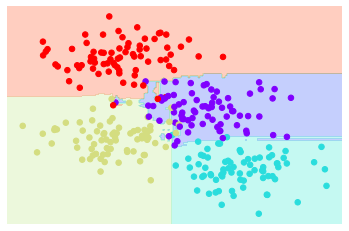

In [34]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

In [35]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

If you want to have reproducible results, it is important to fix the `random_state`.

In [36]:
model.base_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
 model.feature_importances_, model.predict_proba(X)

(array([0.36592094, 0.63407906]),
 array([[0.1 , 0.7 , 0.2 , 0.  ],
        [0.  , 0.  , 0.  , 1.  ],
        [1.  , 0.  , 0.  , 0.  ],
        ...,
        [0.98, 0.  , 0.01, 0.01],
        [0.11, 0.02, 0.  , 0.87],
        [0.  , 0.  , 0.99, 0.01]]))

#### A Note about `n_jobs` parameter:

While building random forests on large dataset might be somewhat time-consuming, it can be parallelized across multiple CPU cores within a computer easily. If you are using a multi-core processor (as nearly all modern computers do), you can use the
n_jobs parameter to adjust the number of cores to use. Using more CPU cores will result in linear speed-ups (using two cores, the training of the random forest will be twice as fast), but specifying n_jobs larger than the number of cores will not help.

You can set `n_jobs`=-1 to use all the cores in your computer.

Random forests have gained huge popularity in applications of machine learning during the last decade due to their good classification performance, scalability, and ease of use. Intuitively, a random forest can be considered as an ensemble of decision trees. The idea behind ensemble learning is to combine weak learners to build a more robust model, a strong learner, that has a better generalization error and is less susceptible to overfitting. The random forest algorithm can be summarized in four simple steps:

1. Draw a random bootstrap sample of size n (randomly choose n samples from the training set with replacement).
2. Grow a decision tree from the bootstrap sample. At each node:
 
   - Randomly select d features without replacement.
   - Split the node using the feature that provides the best split according to the objective function, for instance, by maximizing the information gain.

3. Repeat the steps 1 to 2 k times.
4. Aggregate the prediction by each tree to assign the class label by majority vote. 


There is a slight modification in step 2 when we are training the individual decision trees: instead of evaluating all features to determine the best split at each node, we only consider a random subset of those. Although random forests don't offer the same level of interpretability as decision trees, a big advantage of random forests is that we don't have to worry so much about choosing good hyperparameter values. We typically don't need to prune the random forest since the ensemble model is quite robust to noise from the individual decision trees. The only parameter that we really need to care about in practice is the number of trees k (step 3) that we choose for the random forest. Typically, the larger the number of trees, the better the performance of the random forest classifier at the expense of an increased computational cost.

In [38]:
model.feature_importances_, model.n_classes_

(array([0.36592094, 0.63407906]), 4)

### Bagging vs Random Forest

They both are same techniques except for major difference. In bagging, we only draw a random bootstrap sample and use all the features available while in the case of Random Forest, we also randomly select only a subset of available features. 

### AdaBoost : Leveraging Weak Learners via Adaptive Boosting

In boosting, the ensemble consists of very simple base classifiers, also often referred to as weak learners, that have only a slight performance advantage over random guessing. A typical example of a weak learner would be a decision tree stump. The key concept behind boosting is to focus on training samples that are hard to classify, that is, to let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble. In contrast to bagging,
the initial formulation of boosting, the algorithm uses random subsets of training samples drawn from the training dataset without replacement. The original boosting procedure is summarized in four key steps as follows:

1. Draw a random subset of training samples $d_1$ without replacement from the training set D to train a weak learner $C_1$.
2. Draw second random training subset $d_2$ without replacement from the training set and add 50 percent of the samples that were previously misclassified to train a weak learner $C_2$.
3. Find the training samples $d_3$ in the training set D on which $C_1$ and $C_2$ disagree to train a third weak learner $C_3$ .
4. Combine the weak learners $C_1$,$C_2$, and $C_2$ via majority voting.